### aim: 

use code adapted from SOZONE/ecosystemLooks/seasonalFxnlGroupComposition.ipynb to get, for each year of each model, latitudinally averaged depth averaged ecosystems

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


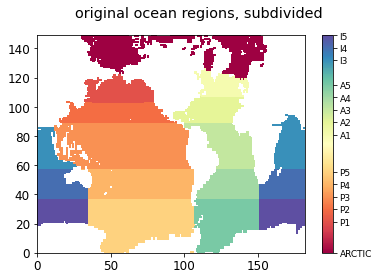

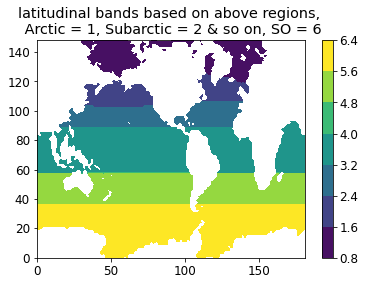

In [4]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('original ocean regions, subdivided')

fact = 0.2
#fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    #plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
# plt.legend(ncol = 5, fontsize = 10)
# plt.suptitle('check that norm of colours works')

plt.figure()
mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 2
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 3
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 4
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 5
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 6

w = plt.contourf(mask_latbands, vmin = 1, vmax = 6)
plt.title('latitudinal bands based on above regions, \n Arctic = 1, Subarctic = 2 & so on, SO = 6')
plt.colorbar(w)

In [5]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

cdepth = tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]
cdepth_broad = np.zeros([12,31,149,182])
for i in range(0,12):
    cdepth_broad[i,:,:,:] = cdepth

In [6]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def gimme_plant(ds, plant):
    '''
    takes ds of type ptrc, calculates seasonal by-lat depth-integrated means of different biological tracers.
    '''
    seas_lat_phyto = np.zeros([12,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[plant] #.groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    
    tmn_test = tmn*cdepth_broad*1000 #* cdepth * 1000 # units in mols/m2 = mols/L * m * L/m3, each depth cell now in mol/m2
    tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum
    
    for s in range(0,12):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_phyto[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_phyto



#     ds.to_netcdf(f'{tdir}{tnam}')



In [7]:
def make_tracer_seas_lat_ptrc(yrst, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/ecosystemLooks/depthint-ptrc/'
    tnam = f'{tdir}{tr}-ptrc-{yrst}.nc'
    print(tnam)
    
    dtype = 'ptrc_T'
    baseDir = '/gpfs/data/greenocean/software/runs/'
    yrend = yrst #
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds = xr.open_dataset(ylist[0])
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrst+1}/01/01",freq='MS',closed='left')

    seas_lat_Alkalini = gimme_plant(ds, 'Alkalini')
    seas_lat_O2 = gimme_plant(ds, 'O2')
    seas_lat_DIC = gimme_plant(ds, 'DIC')
    seas_lat_PIIC = gimme_plant(ds, 'PIIC')    
    
    seas_lat_DOC = gimme_plant(ds, 'DOC')
    seas_lat_CaCO3 = gimme_plant(ds, 'CaCO3')
    seas_lat_ARA = gimme_plant(ds, 'ARA')
    seas_lat_POC = gimme_plant(ds, 'POC')   
    seas_lat_GOC = gimme_plant(ds, 'GOC')   
    
    seas_lat_NO3 = gimme_plant(ds, 'NO3')
    seas_lat_Si = gimme_plant(ds, 'Si')
    seas_lat_PO4 = gimme_plant(ds, 'PO4')
    seas_lat_Fer = gimme_plant(ds, 'Fer')   
    
    seas_lat_DIA = gimme_plant(ds, 'DIA') #phyto
    seas_lat_MIX = gimme_plant(ds, 'MIX')
    seas_lat_COC = gimme_plant(ds, 'COC')
    seas_lat_PIC = gimme_plant(ds, 'PIC')
    seas_lat_PHA = gimme_plant(ds, 'PHA')
    seas_lat_FIX = gimme_plant(ds, 'FIX')

    seas_lat_BAC = gimme_plant(ds, 'BAC') #bacterai

    seas_lat_PRO = gimme_plant(ds, 'PRO') #zoos
    seas_lat_PTE = gimme_plant(ds, 'PTE')
    seas_lat_MES = gimme_plant(ds, 'MES')
    seas_lat_GEL = gimme_plant(ds, 'GEL')
    seas_lat_MAC = gimme_plant(ds, 'MAC')
    
    
    
    data_vars = {
        
                 'Alkalini':(['time_counter',  'lat_band'], seas_lat_Alkalini,
                 {'units': 'mol/m2'}),
                
                 'O2':(['time_counter',  'lat_band'], seas_lat_O2,
                         {'units': 'mol/m2'}),
                 'DIC':(['time_counter',  'lat_band'], seas_lat_DIC,
                         {'units': 'mol/m2'}),
                 'PIIC':(['time_counter',  'lat_band'], seas_lat_PIIC,
                         {'units': 'mol/m2'}),
                 'DOC':(['time_counter',  'lat_band'], seas_lat_DOC,
                         {'units': 'mol/m2'}), 
                 'CaCO3':(['time_counter',  'lat_band'], seas_lat_CaCO3,
                         {'units': 'mol/m2'}),
                 
                 'ARA':(['time_counter',  'lat_band'], seas_lat_ARA,
                         {'units': 'mol/m2'}),
                 
                 'POC':(['time_counter',  'lat_band'], seas_lat_POC,
                         {'units': 'mol/m2'}),
                 'GOC':(['time_counter',  'lat_band'], seas_lat_GOC,
                         {'units': 'mol/m2'}),
                 'NO3':(['time_counter',  'lat_band'], seas_lat_NO3,
                         {'units': 'mol/m2'}),
                 'Si':(['time_counter',  'lat_band'], seas_lat_Si,
                         {'units': 'mol/m2'}),
                 'PO4':(['time_counter',  'lat_band'], seas_lat_PO4,
                         {'units': 'mol/m2'}),
                 'Fer':(['time_counter',  'lat_band'], seas_lat_Fer,
                         {'units': 'mol/m2'}),
                         
        
                 'DIA':(['time_counter',  'lat_band'], seas_lat_DIA,
                         {'units': 'mol/m2'}),
                
                 'MIX':(['time_counter',  'lat_band'], seas_lat_MIX,
                         {'units': 'mol/m2'}),
                 'COC':(['time_counter',  'lat_band'], seas_lat_COC,
                         {'units': 'mol/m2'}),
                 'PIC':(['time_counter',  'lat_band'], seas_lat_PIC,
                         {'units': 'mol/m2'}),
                 'PHA':(['time_counter',  'lat_band'], seas_lat_PHA,
                         {'units': 'mol/m2'}), 
                 'FIX':(['time_counter',  'lat_band'], seas_lat_FIX,
                         {'units': 'mol/m2'}),
                 
        
                 'BAC':(['time_counter',  'lat_band'], seas_lat_BAC,
                         {'units': 'mol/m2'}),
        
        
                 'PRO':(['time_counter',  'lat_band'], seas_lat_PRO,
                         {'units': 'mol/m2'}),
                 'PTE':(['time_counter',  'lat_band'], seas_lat_PTE,
                         {'units': 'mol/m2'}),
                 'MES':(['time_counter',  'lat_band'], seas_lat_MES,
                         {'units': 'mol/m2'}),
                 'GEL':(['time_counter',  'lat_band'], seas_lat_GEL,
                         {'units': 'mol/m2'}),
                 'MAC':(['time_counter',  'lat_band'], seas_lat_MAC,
                         {'units': 'mol/m2'}),
                }

    # define coordinates
    coords = {'time_counter': (['time_counter'], times),\
             'lat_band': (['lat_band'], np.arange(1,7,1)),}

    # define global attributes
    attrs = {'made in':'SOZONE/ecosystemLooks/fxlgroups-intime.ipynb',
             'latitude bands': 'see notebook, 1 is arctic, 6 is SO',
            }
    
#     # create dataset
    ds2 = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)
    
    ds2.to_netcdf(f'{tnam}')
    
    return ds2

In [8]:
#ds2 = make_tracer_seas_lat_ptrc(1990, 'TOM12_TJ_1ASA')

## p

In [9]:

# plt.figure()

# for i in range(0, 6):
#     sodia = ds2.DIA.isel(lat_band = i)

#     plt.plot(sodia.time_counter, sodia, label = i+1)
    
# plt.legend()

In [12]:
ds = xr.open_dataset('/gpfs/data/greenocean/software/runs//TOM12_TJ_1ASA/ORCA2_1m_19900101_19901231_diad_T.nc')
# ds.Si

In [13]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 12, x: 182, y: 149)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 4.999938 15.000288 ... 5250.2266
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 1990-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    DOCTRP                (time_counter, deptht, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    EXP                   (time_counter, deptht, y, x) float32 ...
    GRAMIC                (time_counter, deptht, y, x) float32 ...
    GRAMES                (time_counter, deptht, y, x) float32 ...
    GRAMAC                (time_counter, deptht, y, x) float32 ...
    PPTDOC                (time_counter, deptht, y, x) float32 ...
    PPT                   (time_counter, deptht, y, x) float32 ...
    TChl                  (time_counter, deptht, y, x) float32 ...
    Detrit                (time_counter, deptht, y, x) float32 ...
    Carniv                (time_counter, deptht, y, x) float32 ...
    Herbiv                (time_counter, deptht, y, x) float32 ...
    GRAMICPHY             (time_counter, deptht, y, x) float32 ...
    GRAMESPHY             (time_counter, deptht, y, x) float32 ...
    GRAMACPHY             (time_counter, deptht, y, x) float32 ...
    nitrfix               (time_counter, deptht, y, x) float32 ...
    denitr                (time_counter, deptht, y, x) float32 ...
    DELO2                 (time_counter, deptht, y, x) float32 ...
    vsink                 (time_counter, deptht, y, x) float32 ...
    sinksil               (time_counter, deptht, y, x) float32 ...
    discarb               (time_counter, deptht, y, x) float32 ...
    ExpCO3                (time_counter, deptht, y, x) float32 ...
    ExpARA                (time_counter, deptht, y, x) float32 ...
    GRAGEL                (time_counter, deptht, y, x) float32 ...
    GRAPTE                (time_counter, deptht, y, x) float32 ...
    proara                (time_counter, deptht, y, x) float32 ...
    prococ                (time_counter, deptht, y, x) float32 ...
    D14PRO                (time_counter, deptht, y, x) float32 ...
    D14RES                (time_counter, deptht, y, x) float32 ...
    fdecay                (time_counter, deptht, y, x) float32 ...
    bdecay                (time_counter, deptht, y, x) float32 ...
    ddecay                (time_counter, deptht, y, x) float32 ...
    qtrC14b               (time_counter, y, x) float32 ...
    qtrB14b               (time_counter, y, x) float32 ...
    qtrD14b               (time_counter, y, x) float32 ...
    qintC14b              (time_counter, y, x) float32 ...
    Cflx                  (time_counter, y, x) float32 ...
    PICflx                (time_counter, y, x) float32 ...
    Oflx                  (time_counter, y, x) float32 ...
    dpCO2                 (time_counter, y, x) float32 ...
    pCO2                  (time_counter, y, x) float32 ...
    PPINT                 (time_counter, y, x) float32 ...
Attributes:
    name:         ORCA2_1m_19900101_19901231
    description:  additional planktom diagnostics
    title:        additional planktom diagnostics
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2022-Jul-31 17:28:54 BST